# Noise Model Diagnostics: Residuals Autocorrelation Over Time

This example introduces two noise model diagnostics which are useful for studying the autocorrelation in time series noise.

The general procedure we follow in this notebook is to start by performing a fit (or MCMC inference) assuming an IID noise process. Next, we generate the diagnostic plots from the IID residuals, and see if they suggest that a correlated noise process would be applicable.

## Residuals distance matrix

This diagnostic plot is a distance matrix of the residuals. Correlated noise, such as AR(1) (autoregressive order 1), will cause the distance matrix to exhibit a banded appearance. First, we generate synthetic data according to the logistic model and add IID noise.

In [1]:
from __future__ import print_function
import pints
import pints.toy as toy
import pints.plot
import numpy as np
import matplotlib.pyplot as plt

# Use the toy logistic model
model = toy.LogisticModel()

real_parameters = [0.015, 500]
times = np.linspace(0, 1000, 100)
org_values = model.simulate(real_parameters, times)

# Add independent Gaussian noise
noise = 50
values = org_values + np.random.normal(0, noise, org_values.shape)

# Set up the problem and run the optimisation 
problem = pints.SingleOutputProblem(model, times, values)

score = pints.SumOfSquaresError(problem)
boundaries = pints.RectangularBoundaries([0, 200], [1, 1000])
x0 = np.array([0.5, 500])

found_parameters, found_value = pints.optimise(
    score,
    x0,
    boundaries=boundaries,
    method=pints.XNES,
    )

print('Score at true solution: ')
print(score(real_parameters))

print('Found solution:          True parameters:' )
for k, x in enumerate(found_parameters):
    print(pints.strfloat(x) + '    ' + pints.strfloat(real_parameters[k]))

Minimising error measure
Using Exponential Natural Evolution Strategy (xNES)
Running in sequential mode.
Population size: 6
Iter. Eval. Best      Time m:s
0     6      4147082    0:00.0
1     12     4147082    0:00.0
2     18     4081188    0:00.0
3     24     3790379    0:00.0
20    126    555505.9   0:00.0
40    246    555505.9   0:00.0
60    366    273084.6   0:00.0
80    486    273084.6   0:00.0
100   606    273084.6   0:00.0
120   726    273084.6   0:00.1
140   846    273084.6   0:00.1
160   966    273084.6   0:00.1
180   1086   273084.6   0:00.1
200   1206   273084.6   0:00.1
220   1326   273084.6   0:00.1
240   1446   273084.6   0:00.1
260   1566   273084.6   0:00.1
280   1686   273084.6   0:00.1
300   1806   273084.6   0:00.1
320   1926   273084.6   0:00.1
340   2046   273084.6   0:00.2
356   2136   273084.6   0:00.2
Halting: No significant change for 200 iterations.
Score at true solution: 
281523.7959664885
Found solution:          True parameters:
 1.47122380760594616e-02   

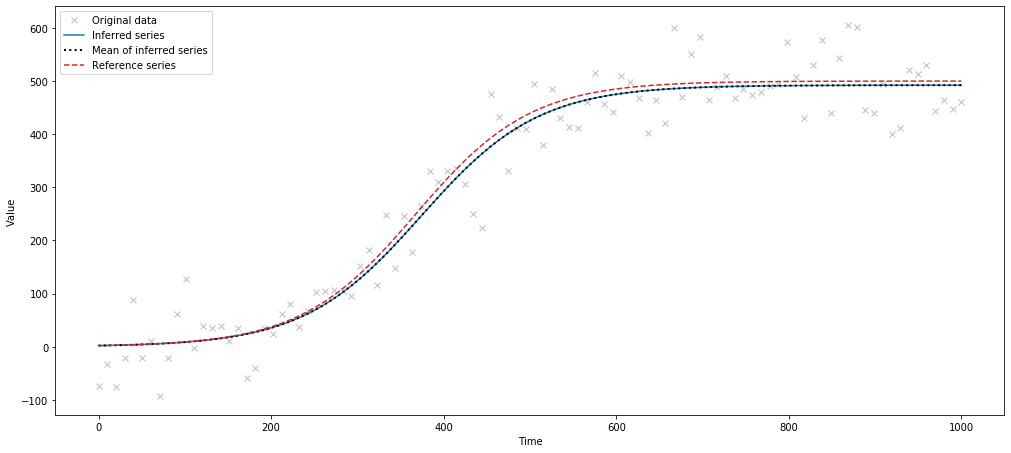

In [2]:
fig, ax = pints.plot.series(np.array([found_parameters]), problem, ref_parameters=real_parameters)
fig.set_size_inches(15, 7.5)
plt.show()

Next, we generate a similar time series, this time with AR(1) noise. 

In [3]:
# Add independent Gaussian noise
rho = 0.85
sigma = 50
values = org_values + pints.noise.ar1(rho, sigma, len(org_values))

# Set up the problem and run the optimisation 
problem_ar1 = pints.SingleOutputProblem(model, times, values)

score = pints.SumOfSquaresError(problem_ar1)
boundaries = pints.RectangularBoundaries([0, 200], [1, 1000])
x0 = np.array([0.5, 500])

found_parameters_ar1, found_value_ar1 = pints.optimise(
    score,
    x0,
    boundaries=boundaries,
    method=pints.XNES,
    )

Minimising error measure
Using Exponential Natural Evolution Strategy (xNES)
Running in sequential mode.
Population size: 6
Iter. Eval. Best      Time m:s
0     6      4638143    0:00.0
1     12     4638143    0:00.0
2     18     1668873    0:00.0
3     24     1668873    0:00.0
20    126    1542272    0:00.0
40    246    1342640    0:00.0
60    366    256593.8   0:00.0
80    486    198582.3   0:00.0
100   606    198581.9   0:00.1
120   726    198581.9   0:00.1
140   846    198581.9   0:00.1
160   966    198581.9   0:00.1
180   1086   198581.9   0:00.1
200   1206   198581.9   0:00.1
220   1326   198581.9   0:00.1
240   1446   198581.9   0:00.1
260   1566   198581.9   0:00.1
280   1686   198581.9   0:00.1
300   1806   198581.9   0:00.1
320   1926   198581.9   0:00.2
340   2046   198581.9   0:00.2
360   2166   198581.9   0:00.2
380   2286   198581.9   0:00.2
400   2406   198581.9   0:00.2
420   2526   198581.9   0:00.2
440   2646   198581.9   0:00.2
460   2766   198581.9   0:00.2
480   28

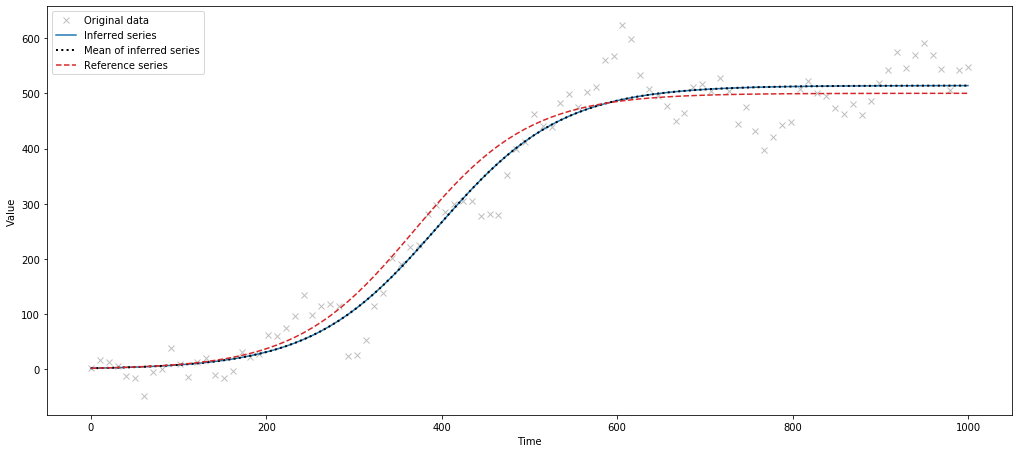

In [4]:
fig, ax = pints.plot.series(np.array([found_parameters_ar1]), problem_ar1, ref_parameters=real_parameters)
fig.set_size_inches(15, 7.5)
plt.show()

Finally, we plot the distance matrix between the residuals for the time series generated above. The plot can be created using the `pints.residuals_diagnostics.plot_residuals_distance` function, which takes as input the fitted parameters and the Pints problem.

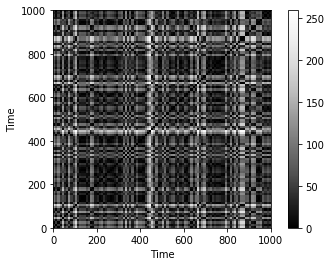

In [5]:
from pints.residuals_diagnostics import plot_residuals_distance

# Plot the distance matrix of the residuals for IID noise
fig = plot_residuals_distance(np.array([found_parameters]),
                              problem)

plt.show()

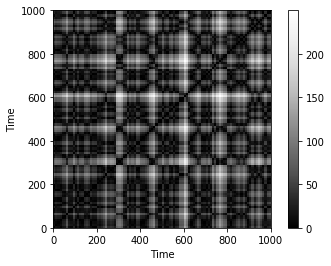

In [6]:
# Plot the distance matrix of the residuals for AR(1) noise
fig = plot_residuals_distance(np.array([found_parameters_ar1]),
                              problem_ar1)

plt.show()

Comparing the two figures above, the matrix for the AR(1) noise time series clearly shows a banded appearance. This plot suggests that the IID noise assumption we made when fitting the model is probably inadequate, and we should rerun the fit using a correlated noise model.

## Binned residuals autocorrelation

The next diagnostic plot divides the time series into consecutive bins, and displays the lag 1 autocorrelation of the residuals calculated within each bin over time. This function is available from Pints using `pints.residuals_diagnostics.plot_residuals_binned_autocorrelation`. 

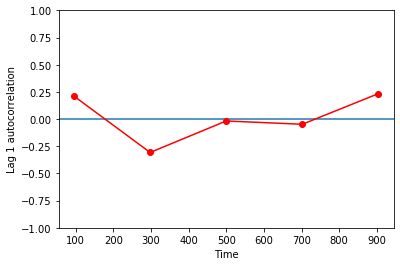

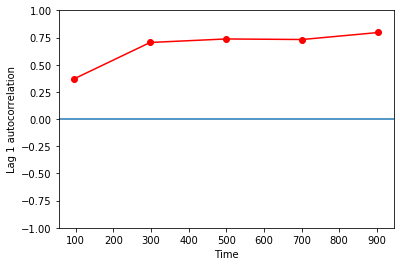

In [7]:
from pints.residuals_diagnostics import plot_residuals_binned_autocorrelation

fig = plot_residuals_binned_autocorrelation(
    np.array([found_parameters]),
    problem,
    n_bins=5
)

fig = plot_residuals_binned_autocorrelation(
    np.array([found_parameters_ar1]),
    problem_ar1,
    n_bins=5
)

plt.show()

Similar to the distance matrix diagnostic, these plots indicate a high autocorrelation over time for the problem with AR(1) noise.

The binned autocorrelation diagnostic is particularly helpful for detecting noise processes in which the level of correlation is changing over time. For a final example, we generate a time series with IID noise in the first half, and AR(1) noise in the second half. As before, we then fit the parameters assuming IID noise, and look at the diagnostic plots to evaluate the noise model.

In [8]:
from __future__ import print_function
import pints
import pints.toy as toy
import pints.plot
import numpy as np
import matplotlib.pyplot as plt

# Use the toy logistic model
model = toy.LogisticModel()

real_parameters = [0.015, 500]
times = np.linspace(0, 1000, 500)
org_values = model.simulate(real_parameters, times)

# Make half IID noise and half AR(1) noise
noise = 50
rho = 0.9
sigma = 50
values = org_values + \
    np.concatenate((np.random.normal(0, noise, len(org_values)//2), 
                    pints.noise.ar1(rho, sigma, len(org_values)//2)))

# Set up the problem and run the optimisation 
problem_mixed = pints.SingleOutputProblem(model, times, values)

score = pints.SumOfSquaresError(problem_mixed)
boundaries = pints.RectangularBoundaries([0, 200], [1, 1000])
x0 = np.array([0.5, 500])

found_parameters_mixed, found_value_mixed = pints.optimise(
    score,
    x0,
    boundaries=boundaries,
    method=pints.XNES,
    )

Minimising error measure
Using Exponential Natural Evolution Strategy (xNES)
Running in sequential mode.
Population size: 6
Iter. Eval. Best      Time m:s
0     6      2e+07      0:00.0
1     12     2e+07      0:00.0
2     18     1.26e+07   0:00.0
3     24     1.26e+07   0:00.0
20    126    2961222    0:00.0
40    246    1173668    0:00.1
60    366    1171053    0:00.1
80    486    1171053    0:00.1
100   606    1171053    0:00.1
120   726    1171053    0:00.1
140   846    1171053    0:00.1
160   966    1171053    0:00.1
180   1086   1171053    0:00.1
200   1206   1171053    0:00.1
220   1326   1171053    0:00.1
240   1446   1171053    0:00.2
260   1566   1171053    0:00.2
280   1686   1171053    0:00.2
300   1806   1171053    0:00.2
320   1926   1171053    0:00.2
340   2046   1171053    0:00.2
351   2106   1171053    0:00.2
Halting: No significant change for 200 iterations.


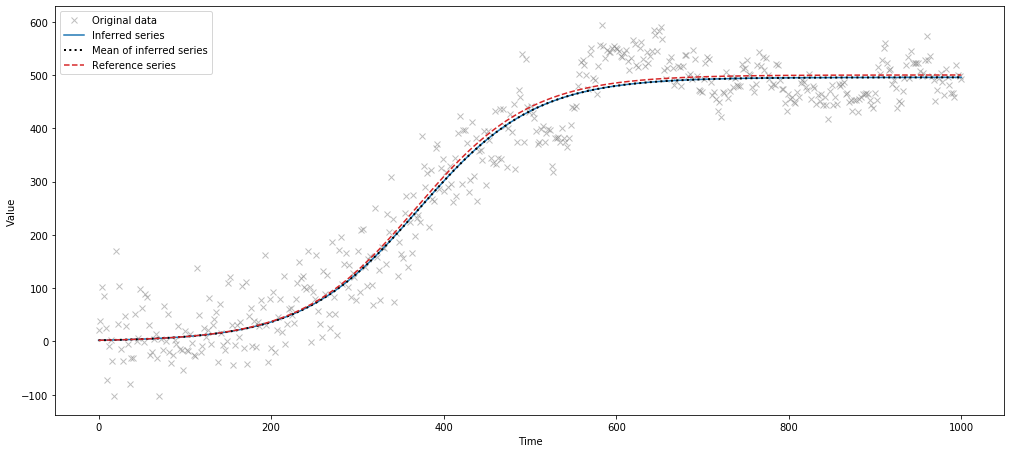

In [9]:
fig, ax = pints.plot.series(np.array([found_parameters_mixed]), problem_mixed, ref_parameters=real_parameters)
fig.set_size_inches(15, 7.5)
plt.show()

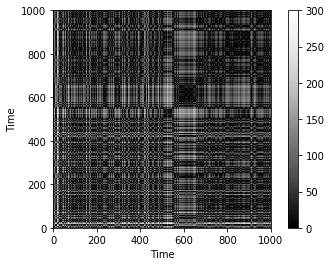

In [10]:
fig = plot_residuals_distance(np.array([found_parameters_mixed]),
                              problem_mixed)

plt.show()

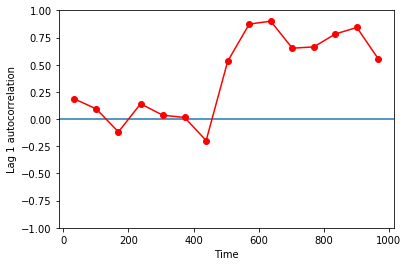

In [11]:
fig = plot_residuals_binned_autocorrelation(
    np.array([found_parameters_mixed]),
    problem_mixed,
    n_bins=15
)

plt.show()

Both of the two diagnostic plots shown above help to reveal the autocorrelated noise that appears in the second half of the time series, from t=500 to t=1000.